Class Tower creates tower object inside a larger rectangle area. 

The tower is initialized as Tower(x1, y1, x2, y2), which (x1, y1) is the bottom-left point of the tower and (x2, y2) is the top-right point. 

Class method "intersection" returns the small tower where two towers are overlapped. Basically, the logic of method "intersection" is that if those four points selected can create a rectangle, then two towers are overlapped.

In [1]:
import itertools

class Tower:
    def intersection(self, other):
        '''
        Check if two Towers are overlapped and return a overlapped tower if they did
        :@param self: Tower, a tower
        :@param other: Tower, another tower
        :@return: Tower, returned overlapped tower
        '''
        assert isinstance(self, Tower) and isinstance(other, Tower)
        
        a, b = self, other
        x1 = max(min(a.x1, a.x2), min(b.x1, b.x2))
        y1 = max(min(a.y1, a.y2), min(b.y1, b.y2))
        x2 = min(max(a.x1, a.x2), max(b.x1, b.x2))
        y2 = min(max(a.y1, a.y2), max(b.y1, b.y2))
        if x1<x2 and y1<y2:
            return type(self)(x1, y1, x2, y2)
        
    __and__ = intersection

    def __init__(self, x1, y1, x2, y2):
        if x1>x2 or y1>y2:
            raise ValueError("Coordinates are invalid")
        self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
        self.area = (y2-y1)*(x2-x1)
        

    def __iter__(self):
        yield self.x1
        yield self.y1
        yield self.x2
        yield self.y2

    def __repr__(self):
        return type(self).__name__+repr(tuple(self))

Method truncate(prev_list, cur) trim new tower's coverage such that its maximum remaining coverage area is retained. 

The idea is that every two horizontal lines(y1, y2...) and vertical lines(x1, x2...) can create a rectangle that matches the restriction above. All lines are selected from previous towers that are overlapped with the current tower. Method "intersection" is used to ensure new trimmed tower is not overlapped with previous towers.

In [2]:
def truncate(prev_list, cur):
    '''
    Trim new tower's coverage such that its maximum remaining coverage area is retained
    :@param prev_list: list, list of previous Towers
    :@param cur: Tower, the tower to be added
    :@return: Tower, returned the modified current Tower
    '''
    import itertools
    assert isinstance(prev_list, list) and isinstance(cur, Tower)
    
    x_list = [cur.x1, cur.x2]
    y_list = [cur.y1, cur.y2]
    for prev in prev_list:
        if(prev & cur != None):
            if( cur.x1 < prev.x1 < cur.x2):
                x_list.append(prev.x1)
            if( cur.x1 < prev.x2 < cur.x2):
                x_list.append(prev.x2)
            if( cur.y1 < prev.y1 < cur.y2):
                 y_list.append(prev.y1)
            if( cur.y1 < prev.y2 < cur.y2):
                 y_list.append(prev.y2)

    width_list = [i for i in itertools.combinations(x_list, 2)]
    height_list = [i for i in itertools.combinations(y_list, 2)]
    
    max_area = 0
    for w in width_list:
        for h in height_list:
            temp = Tower(min(w),min(h),max(w),max(h))      # create numbers of Towers

            if(temp.area > max_area):                      # see if a trimmed Tower has larger area
                i=0  
                non_overlap = True
                while(non_overlap and i < len(prev_list)): # check if it is overlap with all previous Towers
                    if(prev_list[i] & temp != None):       
                        non_overlap = False
                    else:
                        i += 1

                if(non_overlap):                           # if not overlapped, then set it as the max tower
                    max_rect = temp
                    max_area = temp.area
    if(max_area == 0):                                     # if no such tower, return none  
        return None
    else:
        return max_rect

Here is the visualization of how method truncate() works. Three previous towers are the red, pink and blue one. New tower is the one with translucent green. After truncate, the maximum area with light green color is retained.

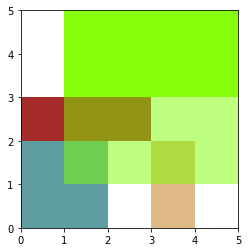

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

color_list = [hex[1] for hex in matplotlib.colors.cnames.items()]

prev_list = [Tower(0, 2, 3, 3), Tower(3, 0, 4, 2), Tower(0, 0, 2, 2)]
cur = Tower(1, 1, 5, 5) 
trimmed = truncate(prev_list, cur)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plt.xlim([0, 5])
plt.ylim([0, 5])

i = 11
for r in prev_list:
    ax.add_patch(patches.Rectangle(( r.x1, r.y1), r.x2-r.x1, r.y2-r.y1,alpha=1.0, 
                                   facecolor= color_list[i]))
    i+=1
    
ax.add_patch(patches.Rectangle(( cur.x1, cur.y1), cur.x2-cur.x1, cur.y2-cur.y1,alpha=0.5, 
                                   facecolor= color_list[i]))

ax.add_patch(patches.Rectangle(( trimmed.x1, trimmed.y1), trimmed.x2-trimmed.x1, trimmed.y2-trimmed.y1,
                               alpha=0.9, facecolor= color_list[i]))
plt.show()    

Method towerGenerator() generate n towers determined by uniform random distribution within the given width and height of the overall area. Then, truncate the tower and retain its maximum area.

Assumption:
`Considering the complexity, when covered area reach to 98% of the overall area, generator will stop iteration as it could be consider as full coverage.`

In [65]:
def towerGenerator(width, height,n):
    '''
    Generate towers randomly and truncate
    :@param width: int, width of overall footprint
    :@param height: int, height of overall footprint
    :@param n: int, number of towers
    :@yield: Tower, returned Tower object
    '''
    import random
    assert isinstance(width, int) and isinstance(height, int) and isinstance(n, int)
    assert width>0 and height>0 and n>0
    prev_list = []
    
    for i in range(n):
        flag = True
        # loop until the condition is matched
        while(flag):  
            x1 = random.randint(0, width-1)
            y1 = random.randint(0, height-1)
            x2 = random.randint(x1+1, width)
            y2 = random.randint(y1+1, height)
            cur = Tower(x1,y1,x2,y2)
            # if covered area more than 98%, stop iteration
            if(sum([p.area for p in prev_list]) >= 0.98*width*height):
                return
            # if a tower is not totally in previous covered area, truncate and add to list
            if truncate(prev_list, cur) != None:
                flag = False
                cur=truncate(prev_list, cur)
                prev_list.append(cur)
                yield cur

Method plot() is a visualization of overall coverage after adding and trimming towers. Every rectangle except the white one represents a tower.

Plot a coverage visualization with 5*5 overall footprint. 
Tower list:  [Tower(3, 2, 4, 5), Tower(4, 2, 5, 5), Tower(1, 0, 3, 4), Tower(1, 4, 3, 5), Tower(0, 1, 1, 4), Tower(3, 1, 5, 2), Tower(3, 0, 5, 1), Tower(0, 0, 1, 1), Tower(0, 4, 1, 5)]
Covered area :  25


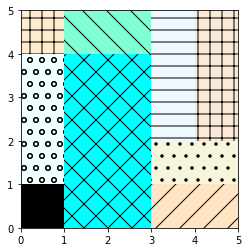

In [112]:
def plot(width, height, rect_list):
    '''
    Visualization of overall coverage after adding and trimming towers.
    :@param width: int, width of overall footprint
    :@param height: int, height of overall foorprint
    :@param rect_list: list, list of Towers
    '''
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib
    assert isinstance(width, int) and isinstance(height, int) and isinstance(rect_list, list)
    assert width>0 and height>0
    
    color_list = [hex[1] for hex in matplotlib.colors.cnames.items()]
    patterns = ['-', '+', 'x', '\\','o', '.', '/']  # more patterns

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.xlim([0, width])
    plt.ylim([0, height])

    i = k = 0
    for r in rect_list:
        ax.add_patch(patches.Rectangle(( r.x1, r.y1), r.x2-r.x1, r.y2-r.y1,
                                       hatch=patterns[k], facecolor= color_list[i]))
        i+=1
        k+=1
        if k == 7:
            k=0
        if i == 148:
            i=0
    plt.show()    
    
rect_list = list(towerGenerator(5, 5, 25))
print('Plot a coverage visualization with 5*5 overall footprint. ')
print('Tower list: ', rect_list)
print('Covered area : ', sum([p.area for p in rect_list]))
plot(5,5,rect_list)


Question 1: Given an overall coverage footprint and a sequence of n towers, what is the resulting resolved coverage?

`To answer this question, method resolvedCoverage() is created. This method takes width and height of overall footprint as input, tries to create n towers and calculates the average coverage ratio for nloops iteration times.`

Example 1: `take width = 5, height = 5, n=5, nloops = 1000 as an example. The plot below shows that coverage ratio on average tends to be steady after 200 iterations. After 1000 iterations, coverage ratio is 0.59.`

Example 2: `take width = 10, height = 10, n=15, nloops = 1000 as an example. The plot below shows that coverage ratio on average tends to be steady after 300 iterations. After 1000 iterations, coverage ratio is 0.77.`

Assumption: `It is considered as full coverage when the ratio is above 0.98.`

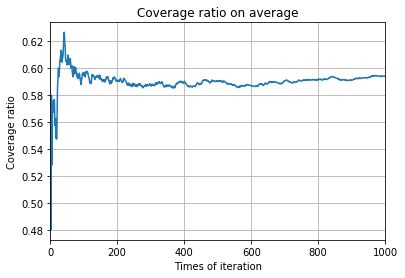

Given the input width is 5 , height is 5 ,number of towers is 5 .
After 1000 iterations, the average coverage ratio is 0.59.


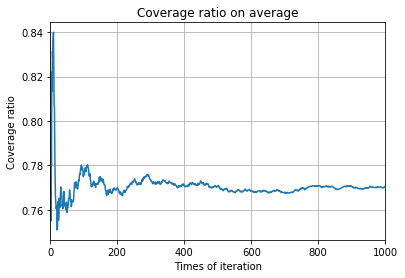

Given the input width is 10 , height is 10 ,number of towers is 15 .
After 1000 iterations, the average coverage ratio is 0.77.


In [107]:
def resolvedCoverage(width, height, n, nloops):
    '''
    On average the resulting resolved coverage, given an overall footprint and a sequence of n towers
    :@param width: int, width of overall footprint
    :@param height: int, height of overall footprint
    :@param n: int, number of towers
    :@param nloops: int, times of iterations
    '''
    import random
    import matplotlib.pyplot as plt        
    assert isinstance(width, int) and isinstance(height, int) 
    assert isinstance(nloops, int)and isinstance(n, int)
    assert width>0 and height>0 and nloops>0 and n>0
    
    ratio = 0
    ratio_list = []
    for i in range(nloops):
        rect_list = list(towerGenerator(width, height, n))
        ratio += sum([p.area for p in rect_list]) / (width*height)
        ratio_list.append(ratio/(i+1))
    
    plt.plot([i for i in range(1,nloops+1)], ratio_list)
    plt.xlim(1, nloops)  
    plt.xlabel('Times of iteration')
    plt.ylabel('Coverage ratio')
    plt.title('Coverage ratio on average')
    plt.grid(True)
    plt.show()
    print('Given the input width is',width,', height is',height, ',number of towers is',n,'.')
    print('After',nloops,'iterations, the average coverage ratio is %.2f.'%(ratio_list[-1]))
            
resolvedCoverage(5, 5, 5,1000)
resolvedCoverage(10, 10,15,1000)

Question 2: Are there any gaps in coverage?

`To answer this question, method gapRatio() is created. This method takes width and height of overall footprint as input, tries to create towers that is determined by uniform random distribution, calculates the average gap ratio for nloops iteration times.`

Example: `take width = 5, height = 5, n=5, nloops = 1000 as an example. The plot below shows that coverage ratio on average tends to be steady after 200 iterations. After 1000 iterations, coverage ratio is 0.16.`

Assumption: `It is considered as full coverage when the ratio is above 0.98.`

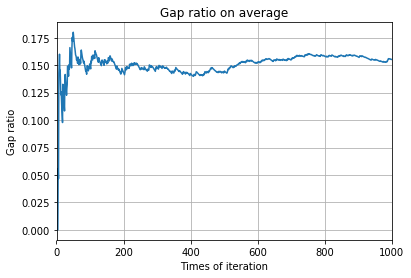

Given the input width is 5 , height is 5 .
After 1000 iterations, the average gap ratio is 0.16.


In [111]:
def gapRatio(width, height,nloops):
    '''
    On average, number of towers are required before full coverage is obtained
    :@param width: int, width of overall footprint
    :@param height: int, height of overall footprint
    :@param nloops: int, n times iteration
    '''
    import random
    import matplotlib.pyplot as plt        
    assert isinstance(width, int) and isinstance(height, int) and isinstance(nloops, int)
    assert width>0 and height>0 and nloops>0
    
    ratio = 0
    ratio_list = []
    for i in range(nloops):
        # number of towers determined by uniform random distribution
        n = random.randint(1, width * height+1)
        rect_list = list(towerGenerator(width, height, n))
        ratio += sum([p.area for p in rect_list]) / (width*height)
        ratio_list.append(1-ratio/(i+1))
    
    plt.plot([i for i in range(1,nloops+1)], ratio_list)
    plt.xlim(1, nloops)  
    plt.xlabel('Times of iteration')
    plt.ylabel('Gap ratio')
    plt.title('Gap ratio on average')
    plt.grid(True)
    plt.show()
    print('Given the input width is',width,', height is',height,'.')
    print('After',nloops,'iterations, the average gap ratio is %.2f.'%(ratio_list[-1]))
            
gapRatio(5, 5, 1000)

Question 3: On average, how many towers are required before full coverage is obtained?

`To answer this question, method avgTowersToFull() is created. This method takes width and height of overall footprint as input and try to create n(n = width * height) towers each iteration time. But it is obvious that the coverage will be full before n is obtained. Then this maximum number of towers is recorded. After all the iterations are finished, print out the number of towers on average.`

`Here, take width = 10, height = 10, nloops = 100 as an example. The plot below shows that number of towers on average tends to be steady after 60 iterations. So 27 towers are required before full coverage is obtained.`
`Take width = 5, height = 5, nloops = 100 as another example. The plot below shows that number of towers on average tends to be steady after 50 iterations. So 11 towers are required before full coverage is obtained.`

Assumption: `It is considered as full coverage when the ratio is above 0.98.`

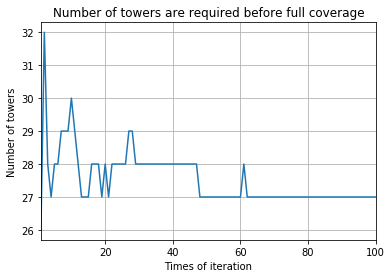

Given the input width is 10 , height is 10 , after 100 iterations, 27 towers are required before full coverage.


In [38]:
def avgTowersToFull(width, height, nloops):
    '''
    On average, number of towers are required before full coverage is obtained
    :@param width: int, width of overall footprint
    :@param height: int, height of overall footprint
    :@param nloops: int, n times iteration
    '''
    import matplotlib.pyplot as plt    
    avg_towers = []
    total_towers = 0
    for i in range(nloops):
        rect_list = list(towerGenerator(width, height, width * height))
        total_towers += len(rect_list)
        avg_towers.append( int(total_towers /  (i+1)))
            
    plt.plot([i for i in range(1,nloops+1)], avg_towers)
    plt.xlim(1, nloops)  
    plt.xlabel('Times of iteration')
    plt.ylabel('Number of towers')
    plt.title('Number of towers are required before full coverage')
    plt.grid(True)
    plt.show()
    print('Given the input width is',width,', height is',height,
          ', after',nloops,'iterations,', avg_towers[-1],'towers are required before full coverage.')

avgTowersToFull(10, 10, 100)

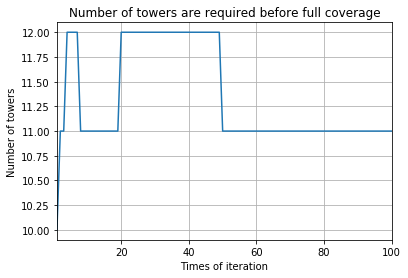

Given the input width is 5 , height is 5 , after 100 iterations, 11 towers are required before full coverage.


In [43]:
avgTowersToFull(5, 5, 100)